In [4]:
# needs a dinFile.txt in fobosworkspace/aes
# make sure that xilinx owns the aes directory
import os
import sys
import shutil
import binascii
import time
import numpy as np
from pynq import allocate
from pynq import Overlay
from foboslib import openadc, projmgr, nexys4dut
from foboslib import pynqlocal as pynqctrl
#######################################################
# File Names and Locations
OVERLAY_FILE    = "/home/xilinx/jupyter_notebooks/fobos_ctrl-serial.bit"
WORKSPACE       = "fobosworkspace"
PROJECT_NAME    = "aes"
DIN_FILE_NAME   = "dinFile.txt"
CIPHER_FILE     = "ciphertext.txt"
TRACE_FILE      = "powerTraces.npy"
DUT_BIT_FILE    = "half_duplex_dut.bit"
#DUT_BIT_FILE    = "FOBOS_DUT.bit"
# Cipher Specific Information
OUT_LEN         = 16 # in bytes 
# Acquisition Configuration
TRACE_NUM       = 10
DUT_CLK         = 0.4
SAMPLING_FREQ   = 40
SAMPLE_NUM      = 2000 # samples per trace
ADC_GAIN        = 50
ADC_HILO        = 1  # 0 - low amplification, 1 - high amplification

In [5]:
# Configure workspace
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()

In [6]:
# Setting up the Control Board
overlay = Overlay(OVERLAY_FILE)
ctrl = pynqctrl.PYNQCtrl(overlay)

In [7]:
ctrl.setDUTClk(DUT_CLK) # kills OUT_LEN does it reset all DUTComm registers?????
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(pynqctrl.PYNQCtrl.TRG_FULL)
ctrl.setDUTInterface(pynqctrl.PYNQCtrl.INTERFACE_4BIT)

clkout 102
2 1 0
clkout 50
divInt
125
divFrac
0.0
divInt
125
divFrac
0
Set clk frequency to 0.4


In [8]:
# Configure trace sampling
fobosAcq = openadc.OpenADCScope(overlay)
#We need to reserve number of block + 2 locations
outputBuffer = allocate(shape=(int(SAMPLE_NUM / 4 + 2),), dtype=np.uint64)
fobosAcq.setAdcClockFreq(SAMPLING_FREQ)
fobosAcq.setGain(ADC_GAIN)
fobosAcq.setHiLo(ADC_HILO)

clkout a01
1 10 0
clkout 1000
divInt
25
divFrac
0.0
divInt
25
divFrac
0
Set clk frequency to 40.0


In [9]:
##########################
# configure and program DUT Nexys 4
#dut = nexys4dut.Nexys4DUT()
#bitFile = os.path.join(projDir, DUT_BIT_FILE)
#dut.setBitFile(bitFile)
#dut.program()

##########################
# configure and program DUT CW305
ctrl.dutctrl.write(0x38,0x01)

In [11]:
##########################
#setup i/o files
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
print("Copying test-vector file to attempt directory ...")
shutil.copy(tvFileName, captureDir)
#########################
print("Loading test-vector file ...")
#testVectors = tvFile.read().splitlines(keepends=False)
testVectors = tvFile.readlines()
print("Done loading.")
tic = time.time()
#traces = np.empty((TRACE_NUM, SAMPLE_NUM))
for traceNum in range(TRACE_NUM):
    fobosAcq.arm(outputBuffer,int(SAMPLE_NUM/4))
    result = ctrl.processData(testVectors[traceNum])
    fobosAcq.waitForTrace()
    #change data type before saving
    trace = outputBuffer.view('uint16')
    #trace= trace[:SAMPLE_NUM]
    #traces[traceNum, :] = trace
    cipherFile.write(result + '\n')
    #c = fvrFile.read(1)
    #if c == "0":
        #numpy.save(traceFile0, trace)
     #   ttestCalc.addTrace(trace, 0)
    #else:
     #   ttestCalc.addTrace(trace, 1)
        #numpy.save(traceFile1, trace)
    np.save(traceFile, trace)
    if traceNum % 20000 == 0:
        sys.stdout.write("Progress: {}%\r".format(traceNum/TRACE_NUM *100 ))
        sys.stdout.flush()
        #ttestPlotFile = os.path.join(captureDir, "ttest{}".format(traceNum))
        #ttestCalc.plot(ttestPlotFile)
    #time.sleep(4)
#numpy.save(traceFile,traces)
#traces = None #Free memory
outputBuffer.freebuffer()
cipherFile.close()
tvFile.close()
traceFile.close()
    
toc = time.time()

print("Time elapsed = {} seconds.".format(toc - tic))

Successfully created new capture directory at fobosworkspace/aes/capture/attempt-01
Copying test-vector file to attempt directory ...
Loading test-vector file ...
Done loading.
Time elapsed = 0.08906364440917969 seconds.


In [12]:
print(result)

8a d1 16 ce d6 86 7b d4 5d 71 4b c9 3c 45 ca c9


fobosworkspace/aes/capture/attempt-01/powerTraces.npy


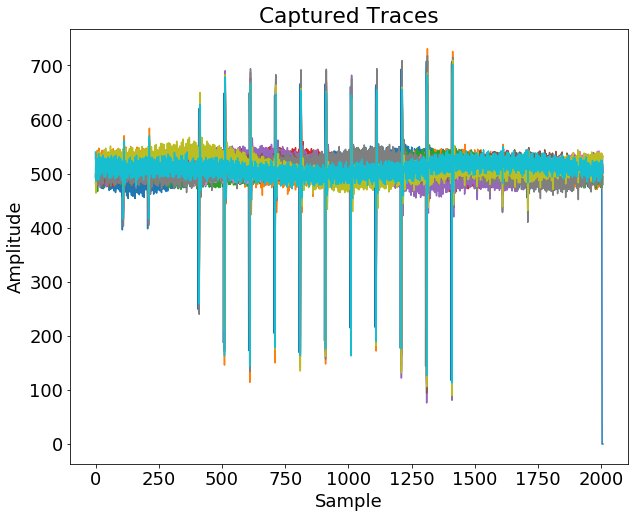

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
traceFile = open(traceFileName, 'rb')
print(traceFileName)
maxtrace = 100
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Captured Traces')
for i in range(min(maxtrace, TRACE_NUM)):
    trace = np.load(traceFile)
    plt.plot(trace)
plt.savefig(os.path.join(captureDir,"aes.png"))
plt.show()
traceFile.close()

In [14]:
TRACE_NUM

10